# First tests with Fourier Domain Adaptation

## Requirements

In [2]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))

import torch
import pyvips
import deeplake
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

'''from utils.constants import (
    RAW_DIR, 
    PATCH_DIR,
    ASSET_DIR,
    SEVERITY_COLOR_MAP
)'''

'''from utils import (
    img_transform_fn
)'''

'from utils import (\n    img_transform_fn\n)'

## Verification of the dataset

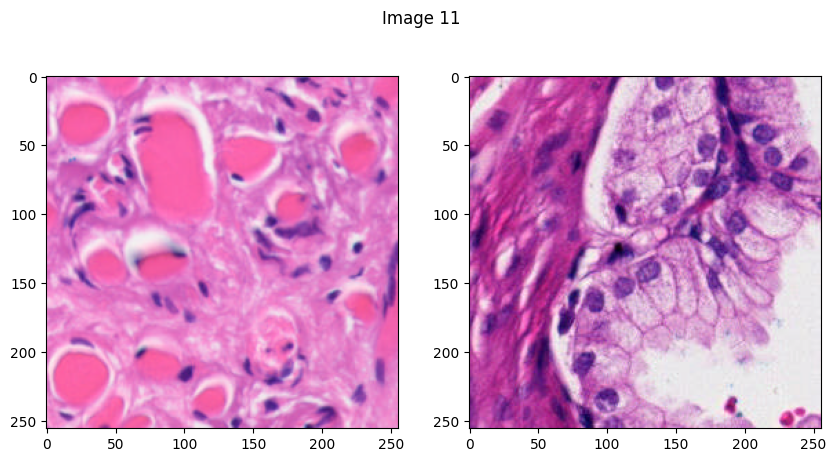

KeyboardInterrupt: 

In [16]:
import time
from IPython.display import clear_output
#test automatique du bon fonctionnement du dataset
for i in range(1,25+1):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    ds = deeplake.open_read_only(dataset_path)
    axes[0].imshow(ds[200]["patch"])
    #plt.show()
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_KFBio"
    ds = deeplake.open_read_only(dataset_path)
    axes[1].imshow(ds[200]["patch"])
    plt.suptitle(f"Image {i+1}")
    plt.show()
    time.sleep(4)
    clear_output(wait=True)

## Visualisation of Akoya and unmodified KFBio

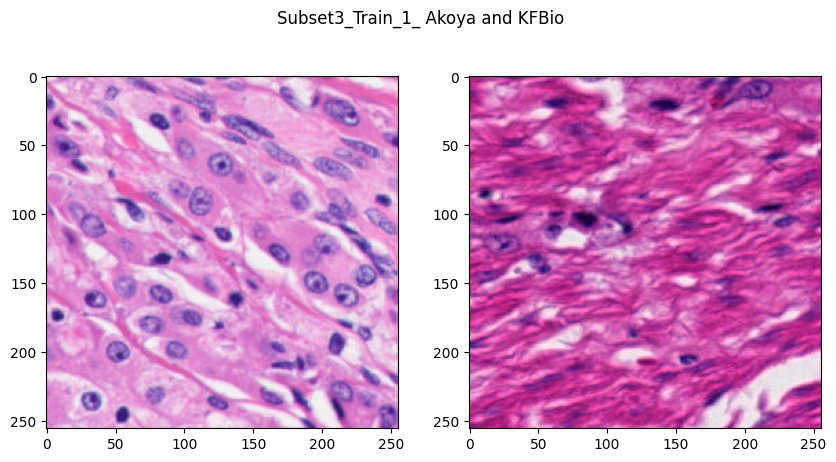

Akoya 1 shape: (256, 256, 3)


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dataset_path_akoya_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_Akoya"
akoya_1 = deeplake.open_read_only(dataset_path_akoya_1)
axes[0].imshow(akoya_1[200]["patch"])
#plt.show()
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)
axes[1].imshow(KFBio_1[200]["patch"])
plt.suptitle(f"Subset3_Train_1_ Akoya and KFBio")
plt.savefig("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/akoya_vs_KFBio.svg")
plt.show()



#shape
print(f"Akoya 1 shape: {akoya_1[200]['patch'].shape}") #(256, 256, 3)

We can see that KFBio is much darker than Akoya, which resulted in worse performances.

## Global Fourier Domain Adaptation
Inspired from Yanchao Yang & Stefano Soatto 2020, git available at https://github.com/YanchaoYang/FDA.git

### Pairwise migration

Here, we try to make one KFBio image closer from one reference Akoya image using Fourier analysis.

Time taken for FDA: 0.038407325744628906 seconds


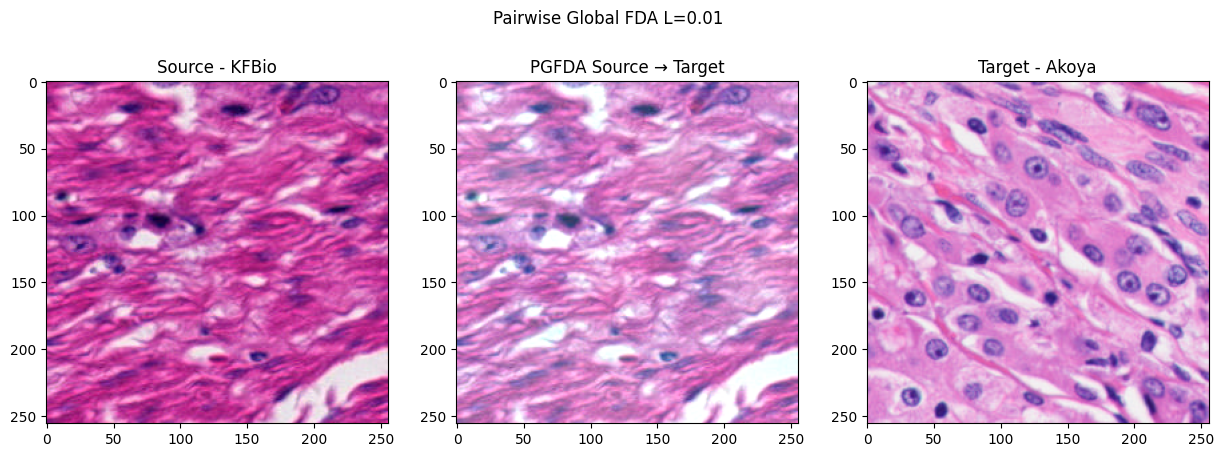

In [5]:
def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


#Test
src_img = KFBio_1[200]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
trg_img = akoya_1[200]["patch"].transpose((2, 0, 1))
L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
start_time = time.time()
PGFDA_KFBio_1 = FDA_source_to_target_np( src_img, trg_img, L_hyperparam )
end_time = time.time()
print(f"Time taken for FDA: {end_time - start_time} seconds")   

#display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(src_img.transpose((1, 2, 0)).astype(np.uint8))
axes[0].set_title("Source - KFBio")

axes[1].imshow(np.clip(PGFDA_KFBio_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1].set_title("PGFDA Source → Target")

axes[2].imshow(trg_img.transpose((1, 2, 0)).astype(np.uint8))
axes[2].set_title("Target - Akoya")

plt.suptitle(f"Pairwise Global FDA L={L_hyperparam}")
plt.savefig(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/pairwise_global_FDA_L={L_hyperparam}.svg")




In [6]:
KFBio_1[0]["label"]

array(3, dtype=int32)

## Mean migration

As we are dealing with multiple patches from multiple images, it is important to know which reference we should select to migrate image. Here, we try to compute the average of the low frequencies from all patches coming from all images from Akoya scanner (in the subset 3). 

Careful: computing the average takes about 30min, but once we have computed it we can store this value and use is again later. 

In [87]:
#code for mean target amplitude
def target_amplitude(img):
    img = img.astype(np.float32)
    fft_img = np.fft.fft2(img, axes=(-2, -1))
    amplitude = np.abs(fft_img)
    return amplitude

big_average = np.zeros((3, 256, 256)) 
total_patches = 0

for i in range(1, 26+1):
    dataset_path_akoya = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    akoya = deeplake.open_read_only(dataset_path_akoya)
    
    # Initialization
    init_patch = akoya[0]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
    sum_amplitude = np.zeros_like(target_amplitude(init_patch))
    current_patches = 0  

    # Loop on patches
    for j in range(len(akoya)):
        target_image = akoya[j]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
        if target_image.shape != (3, 256, 256):
            continue  # skip invalid patches
        amplitude = target_amplitude(target_image)
        sum_amplitude += amplitude
        current_patches += 1  
        total_patches += 1     

    average_amplitude = sum_amplitude / current_patches
        
    np.save(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/average_amplitude_akoya_{i}.npy", average_amplitude)
    print(f"Average amplitude saved for dataset {i}.")

    big_average += average_amplitude

general_average = big_average / 26
np.save(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy", general_average)
print(f"Global average computed from {total_patches} total patches across 26 datasets")

Average amplitude saved for dataset 1.
Average amplitude saved for dataset 2.
Average amplitude saved for dataset 3.
Average amplitude saved for dataset 4.
Average amplitude saved for dataset 5.
Average amplitude saved for dataset 6.
Average amplitude saved for dataset 7.
Average amplitude saved for dataset 8.
Average amplitude saved for dataset 9.
Average amplitude saved for dataset 10.
Average amplitude saved for dataset 11.
Average amplitude saved for dataset 12.
Average amplitude saved for dataset 13.
Average amplitude saved for dataset 14.
Average amplitude saved for dataset 15.
Average amplitude saved for dataset 16.
Average amplitude saved for dataset 17.
Average amplitude saved for dataset 18.
Average amplitude saved for dataset 19.
Average amplitude saved for dataset 20.
Average amplitude saved for dataset 21.
Average amplitude saved for dataset 22.
Average amplitude saved for dataset 23.
Average amplitude saved for dataset 24.
Average amplitude saved for dataset 25.
Average a

In [73]:
print(general_average)

[[[14631352.80769231   162868.62379808   118113.02253606 ...
      96069.64588341   118113.02253606   162868.62379808]
  [  162907.81941106   133439.83143029   108100.08759014 ...
      91899.81144832   109795.6413762    134740.42728365]
  [  118168.77764423   107860.1421274     94853.7094351  ...
      85050.13025841    96833.79356971   108671.68464543]
  ...
  [   96402.53290264    91925.94320913    85207.30183293 ...
      75923.37469952    83586.17382812    91280.38822115]
  [  118168.77764423   108671.68464543    96833.79356971 ...
      83254.9624399     94853.7094351    107860.1421274 ]
  [  162907.81941106   134740.42728365   109795.6413762  ...
      90507.08097957   108100.08759014   133439.83143029]]

 [[10649982.01923077   265379.12199519   179097.94320913 ...
     137197.33022837   179097.94320913   265379.12199519]
  [  264290.14903846   208585.54026442   157863.86899038 ...
     128892.91225962   162482.46424279   213014.890625  ]
  [  179889.25721154   158568.2280649   

Testing Average Global FDA

Time taken for AGFDA: 0.023256301879882812 seconds


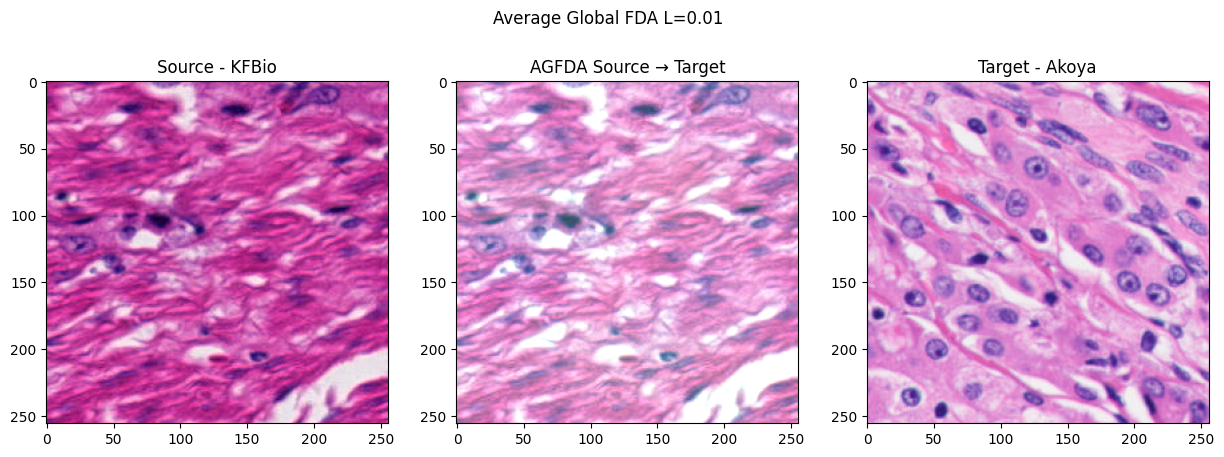

In [8]:
def modif_FDA_source_to_target_np( src_img, amp_trg, L=0.1 ):
    fft_src_np = np.fft.fft2( src_img, axes=(-2, -1) )
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


#Test
src_img = KFBio_1[200]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
trg_img = akoya_1[200]["patch"].transpose((2, 0, 1))
L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
general_average = np.load(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy") 
start_time = time.time()
AGFDA_KFBio_1 = modif_FDA_source_to_target_np( src_img, general_average, L=L_hyperparam)
end_time = time.time()
print(f"Time taken for AGFDA: {end_time - start_time} seconds")   

#display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(src_img.transpose((1, 2, 0)).astype(np.uint8))
axes[0].set_title("Source - KFBio")

axes[1].imshow(np.clip(AGFDA_KFBio_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1].set_title("AGFDA Source → Target")

axes[2].imshow(trg_img.transpose((1, 2, 0)).astype(np.uint8))
axes[2].set_title("Target - Akoya")

plt.suptitle(f"Average Global FDA L={L_hyperparam}")
plt.savefig(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/average_global_FDA_L={L_hyperparam}.svg")

Pairwise VS Average Global Fourier Domain Adaptation visualisation

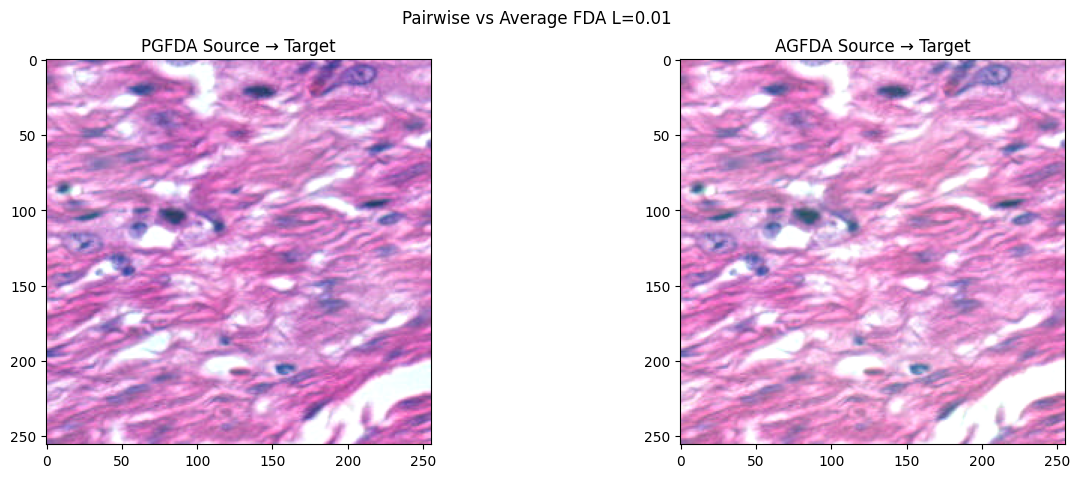

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(np.clip(PGFDA_KFBio_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[0].set_title("PGFDA Source → Target")

axes[1].imshow(np.clip(AGFDA_KFBio_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1].set_title("AGFDA Source → Target")

plt.suptitle(f"Pairwise vs Average FDA L={L_hyperparam}")
plt.savefig(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/pairwise_vs_average_L={L_hyperparam}.svg")

## Average Label-based Fourier Domain Adaptation

Taking the general average is maybe too rough. Here we propose a more nuanced adaptation: the goal is to migrate the image appearance of one image to the closest candidate among the average amplitude for each label. 

Description of the pipeline:


1. **Compute Average Amplitude for Each Label**: (To be done only once!) Calculate the average amplitude for each label. 

2. **Extract Amplitude from unkown scanner**: From the unknown patch, extract its amplitude. 

3. **Focus on Relevant Portion**: Extract the portion of the amplitude that will be swapped with amplitudes from Akoya, do the same for each label-based Akoya amplitudes. 

4. **Find Shortest Matrix Distance**: You compute the distance between the amplitude matrix of the unknown patch and each of the label-based amplitude matrices. The goal is to find the label whose average amplitude is closest to the unknown patch's amplitude.

5. **Compute Transformation**: Once the closest match is found, compute the transformation to migrate the appearance of the unknown patch to match the closest label-based amplitude.



In [99]:
#1: Average amplitude for each label from Akoya

from collections import defaultdict

# Dictionary to store sum and count for each label
label_sums = defaultdict(lambda: np.zeros((3, 256, 256)))  # Assuming target_amplitude returns (3, 256, 256)
label_counts = defaultdict(int)

for i in range(1, 26+1):
    dataset_path_akoya = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    akoya = deeplake.open_read_only(dataset_path_akoya)
    
    print(f"Processing dataset {i}...")
    
    # Loop on patches
    for j in range(len(akoya)):
        target_image = akoya[j]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
        if target_image.shape != (3, 256, 256):
            continue  # skip invalid patches
            
        # Extract label for current patch
        label = akoya[j]["label"]
        
        # Convert label to hashable type (handle different label formats)
        if isinstance(label, np.ndarray):
            if label.size == 1:
                # Single value array
                label = label.item()
            else:
                # Multi-dimensional array - convert to tuple
                label = tuple(label.flatten())
        elif hasattr(label, 'numpy'):
            # Handle tensor-like objects
            label = label.numpy()
            if label.size == 1:
                label = label.item()
            else:
                label = tuple(label.flatten())
        
        # Compute amplitude for this patch
        amplitude = target_amplitude(target_image)
        
        # Add to the corresponding label's sum
        label_sums[label] += amplitude
        label_counts[label] += 1

    print(f"Dataset {i} processed.")

# Compute average for each label and save
for label in label_sums.keys():
    if label_counts[label] > 0:
        average_amplitude = label_sums[label] / label_counts[label]
        
        # Save the average for this label
        np.save(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/label_based_average/average_label_{label}_akoya.npy", average_amplitude)
        print(f"Average amplitude saved for label {label} (computed from {label_counts[label]} patches).")
    else:
        print(f"Warning: No patches found for label {label}")

print(f"Processing complete. Found labels: {list(label_sums.keys())}")


Processing dataset 1...
Dataset 1 processed.
Processing dataset 2...
Dataset 2 processed.
Processing dataset 3...
Dataset 3 processed.
Processing dataset 4...
Dataset 4 processed.
Processing dataset 5...
Dataset 5 processed.
Processing dataset 6...
Dataset 6 processed.
Processing dataset 7...
Dataset 7 processed.
Processing dataset 8...
Dataset 8 processed.
Processing dataset 9...
Dataset 9 processed.
Processing dataset 10...
Dataset 10 processed.
Processing dataset 11...
Dataset 11 processed.
Processing dataset 12...
Dataset 12 processed.
Processing dataset 13...
Dataset 13 processed.
Processing dataset 14...
Dataset 14 processed.
Processing dataset 15...
Dataset 15 processed.
Processing dataset 16...
Dataset 16 processed.
Processing dataset 17...
Dataset 17 processed.
Processing dataset 18...
Dataset 18 processed.
Processing dataset 19...
Dataset 19 processed.
Processing dataset 20...
Dataset 20 processed.
Processing dataset 21...
Dataset 21 processed.
Processing dataset 22...
Datase

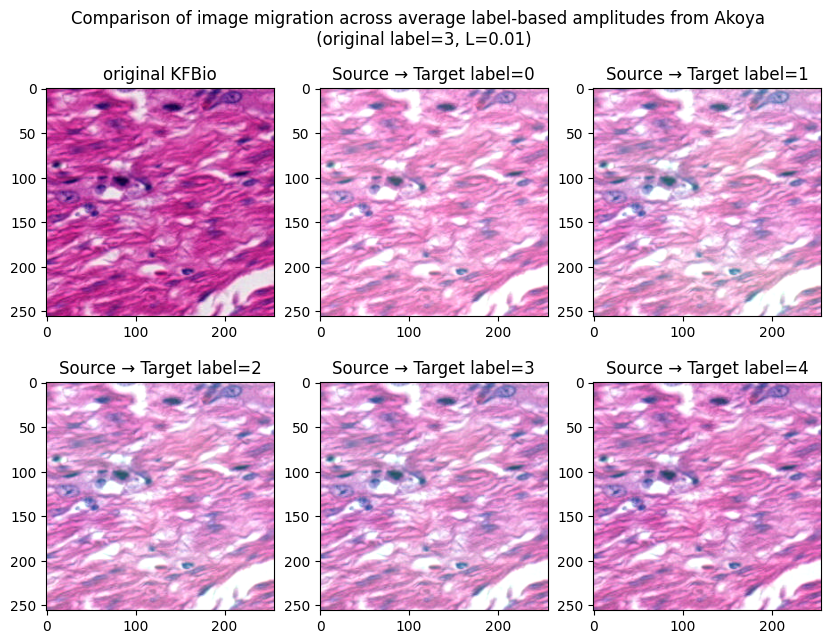

In [ ]:
# Display of the appearance of the same image for different average label-based amplitude. 

def image_to_label(src_img, label, L_hyperparam=0.1):
    # computes the transformation of KBio images to the label-based amplitude
    trg_amp = np.load(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/label_based_average/average_label_{label}_akoya.npy")
    return modif_FDA_source_to_target_np( src_img, trg_amp, L=L_hyperparam)


src_img = KFBio_1[200]["patch"].transpose((2, 0, 1))  # (3, 256, 256)

L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
   

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0,0].imshow(src_img.transpose((1, 2, 0)).astype(np.uint8))
axes[0,0].set_title("original KFBio")

KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam) 
axes[0,1].imshow(np.clip(KFBio_to_0, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[0,1].set_title("Source → Target label=0")

KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam) 
axes[0,2].imshow(np.clip(KFBio_to_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[0,2].set_title("Source → Target label=1")

KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam) 
axes[1,0].imshow(np.clip(KFBio_to_2, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1,0].set_title("Source → Target label=2")

KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam) 
axes[1,1].imshow(np.clip(KFBio_to_3, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1,1].set_title("Source → Target label=3")

KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam) 
axes[1,2].imshow(np.clip(KFBio_to_4, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1,2].set_title("Source → Target label=4")


plt.suptitle(f"Comparison of image migration across average label-based amplitudes from Akoya \n (original label={KFBio_1[200]["label"]}, L={L_hyperparam})")
plt.savefig(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/label_based_visualisation_L={L_hyperparam}.svg")

In [ ]:
# Function for closest reduced amplitude matrix
def closest_average_amplitude(src_amp, trg_amp):
    # Reduce the dimensions of the matrices
    
    # Compute distance
    

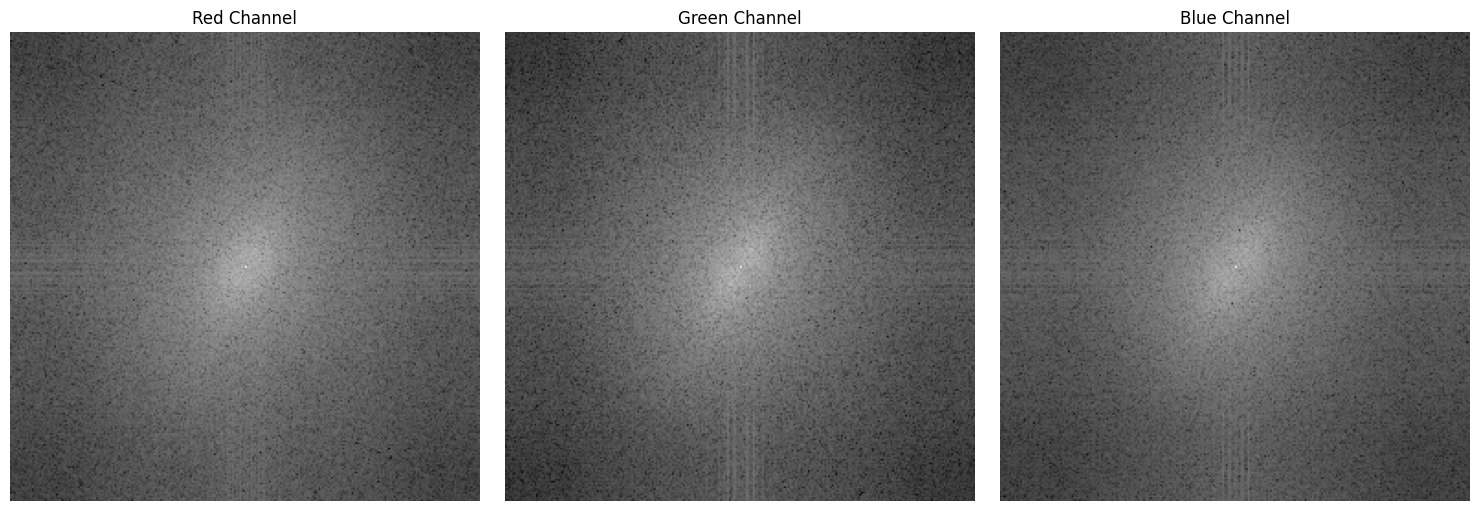

In [56]:
#test
#Display of the amplitude spectrum for RGB

def amplitude_spectrum_per_channel(img):
    """
    Computes the log-amplitude spectrum for each channel in a CHW image.

    Args:
        img (np.ndarray): Image in shape (C, H, W), float32 or uint8.

    Returns:
        List[np.ndarray]: Log-amplitude spectrum for each channel.
    """
    img = img.astype(np.float32)
    spectra = []

    for c in range(img.shape[0]):
        fft = np.fft.fft2(img[c])                 # FFT per channel
        fft_shift = np.fft.fftshift(fft)          # Shift low-freq to center
        amplitude = np.abs(fft_shift)
        log_amp = np.log1p(amplitude)             # log(1 + x) for stability
        spectra.append(log_amp)

    return spectra

# Apply to target image (CHW format)
spectra = amplitude_spectrum_per_channel(trg_img)

# Plot each channel's spectrum
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].imshow(spectra[i], cmap='gray')
    axes[i].set_title(channel_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()
